<a href="https://colab.research.google.com/github/ganesh-codes404/EMNIT_Analysis/blob/main/DLassign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip cache purge
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Files removed: 0
Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0+cpu which is incompatible.


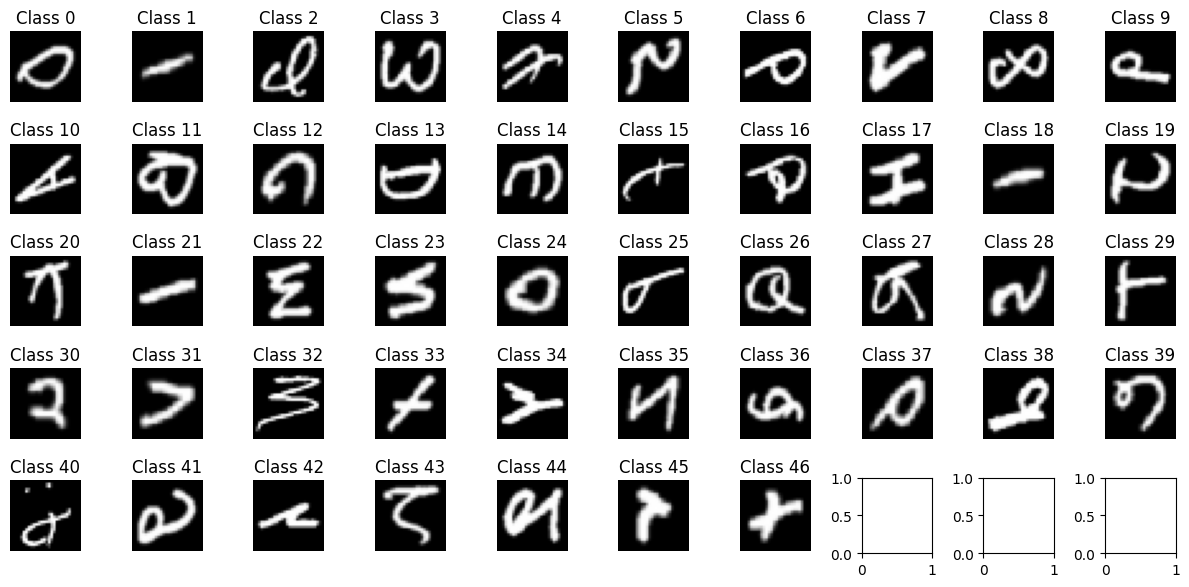

Training: Hidden Layers=[128, 64, 32], Learning Rate=0.001, Optimizer=sgd, Batch Size=128
Epoch 1: Loss=16695.7635, Train Acc=0.0609, Val Acc=0.0823
Epoch 2: Loss=16159.5262, Train Acc=0.0698, Val Acc=0.0874
Epoch 3: Loss=14900.9085, Train Acc=0.1010, Val Acc=0.1198
Epoch 4: Loss=13880.3674, Train Acc=0.1384, Val Acc=0.1902
Epoch 5: Loss=12603.3764, Train Acc=0.2688, Val Acc=0.3505
Epoch 6: Loss=11021.2326, Train Acc=0.3792, Val Acc=0.4079
Epoch 7: Loss=9538.0017, Train Acc=0.4262, Val Acc=0.4434
Epoch 8: Loss=8626.0433, Train Acc=0.4607, Val Acc=0.4763
Epoch 9: Loss=8035.3364, Train Acc=0.4884, Val Acc=0.4986
Epoch 10: Loss=7587.0417, Train Acc=0.5093, Val Acc=0.5183
Training: Hidden Layers=[128, 64, 32], Learning Rate=0.001, Optimizer=sgd, Batch Size=64
Epoch 1: Loss=32598.5293, Train Acc=0.0519, Val Acc=0.1098
Epoch 2: Loss=28179.2184, Train Acc=0.1618, Val Acc=0.2547
Epoch 3: Loss=22032.7633, Train Acc=0.3679, Val Acc=0.4323
Epoch 4: Loss=17061.4058, Train Acc=0.4649, Val Acc=0.503

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import confusion_matrix
from itertools import product

# Define dataset transformations
data_transform = transforms.Compose([transforms.ToTensor()])

# Load EMNIST dataset (Balanced)
train_data = torchvision.datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=data_transform)

# Function to display sample images from different classes
def visualize_samples(dataset, num_classes=47):
    """Displays one sample from each class in the dataset."""
    sample_dict = {i: None for i in range(num_classes)}

    for img, label in dataset:
        if sample_dict[label] is None:
            sample_dict[label] = img.squeeze()
        if all(v is not None for v in sample_dict.values()): # Changed this line to check for None instead of truthiness of tensors
            break

    fig, axes = plt.subplots(5, 10, figsize=(12, 6))
    for i, ax in enumerate(axes.flatten()):
        if i < num_classes:
            ax.imshow(sample_dict[i], cmap='gray')
            ax.set_title(f'Class {i}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a few samples
visualize_samples(train_data)

# Load EMNIST (By Class) for training and testing
dataset = torchvision.datasets.EMNIST(root="./data", split="byclass", train=True, download=True, transform=data_transform)
test_dataset = torchvision.datasets.EMNIST(root="./data", split="byclass", train=False, download=True, transform=data_transform)

# Split training data into train and validation sets
train_size = int(len(dataset) * 0.75)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define a Feed-Forward Neural Network model
class CharacterClassifier(nn.Module):
    def __init__(self, input_dim=28*28, hidden_units=[128, 64, 32], output_dim=62, activation=nn.ReLU):
        super().__init__()
        layers = []
        previous_layer = input_dim
        for units in hidden_units:
            layers.append(nn.Linear(previous_layer, units))
            layers.append(activation())
            previous_layer = units
        layers.append(nn.Linear(previous_layer, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        return self.network(x)

# Function to train and evaluate the model
def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=5, device="cpu"):
    model.to(device)
    best_validation_acc = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct_preds, total_samples = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += (predictions.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)

        train_accuracy = correct_preds / total_samples

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        validation_accuracy = val_correct / val_total
        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Train Acc={train_accuracy:.4f}, Val Acc={validation_accuracy:.4f}")

        # Save best model
        if validation_accuracy > best_validation_acc:
            best_validation_acc = validation_accuracy
            torch.save(model.state_dict(), "best_model.pth")

# Hyperparameter options
hidden_layer_configs = [[128, 64, 32], [64, 64, 64], [128, 128, 64]]
learning_rates = [1e-3, 1e-4]
optimizers_list = ['sgd', 'adam', 'rmsprop', 'adadelta', 'adagrad']
batch_sizes = [128, 64]

# Find best hyperparameter combination
best_val_acc = 0
best_hyperparams = None

for hidden_layers, lr, opt_type, batch_size in product(hidden_layer_configs, learning_rates, optimizers_list, batch_sizes):
    print(f"Training: Hidden Layers={hidden_layers}, Learning Rate={lr}, Optimizer={opt_type}, Batch Size={batch_size}")

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = CharacterClassifier(hidden_units=hidden_layers)

    # Select optimizer
    if opt_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif opt_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif opt_type == 'adadelta':
        optimizer = optim.Adadelta(model.parameters(), lr=lr)
    elif opt_type == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr)

    # Train model
    train_and_validate(model, train_loader, val_loader, optimizer, nn.CrossEntropyLoss(), num_epochs=10)

    # Evaluate on validation data
    model.eval()
    correct_predictions, total_samples = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to("cpu"), labels.to("cpu")
            outputs = model(images)
            correct_predictions += (outputs.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)

    validation_accuracy = correct_predictions / total_samples
    if validation_accuracy > best_val_acc:
        best_val_acc = validation_accuracy
        best_hyperparams = (hidden_layers, lr, opt_type, batch_size)
        torch.save(model.state_dict(), "best_hyperparam_model.pth")

print(f"Best Configuration: {best_hyperparams} with Accuracy: {best_val_acc:.4f}")

# Load the best model and generate a confusion matrix
best_model = CharacterClassifier(hidden_units=best_hyperparams[0])
best_model.load_state_dict(torch.load("best_hyperparam_model.pth"))
best_model.eval()

# Test dataset loader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

all_preds, all_labels = [], []

# Collect predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to("cpu"), labels.to("cpu")
        outputs = best_model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, cmap="Blues", fmt="d", annot=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


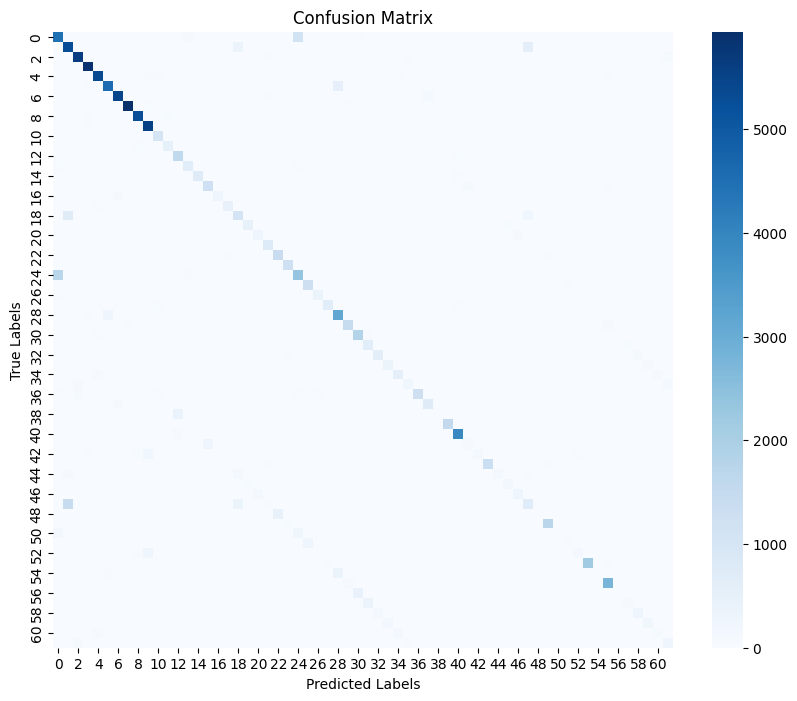

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
best_model = FeedForwardNN(hidden_layers=best_config[0])
best_model.load_state_dict(torch.load("best_hyperparam_model.pth"))
best_model.eval()

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to("cpu"), labels.to("cpu")
        outputs = best_model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
